In [77]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import folium
from folium import plugins
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from branca.colormap import LinearColormap
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

# Load processed data - USE NEW FILE
census_bg = gpd.read_file('data/processed/census_bg_exposure.shp')
honolulu = gpd.read_file('data/processed/honolulu_boundary.shp')
waterways = gpd.read_file('data/processed/waterways_honolulu.shp')
lines = gpd.read_file('data/processed/lines_honolulu.shp')

# Fix truncated shapefile column names
census_bg = census_bg.rename(columns={
    'total_popu': 'total_population',
    'pixels_mod': 'pixels_moderate',
    'pixels_hig': 'pixels_high',
    'pixels_tot': 'pixels_total',
    'pct_modera': 'pct_moderate',
    'pop_low_ri': 'pop_low_risk',
    'pop_modera': 'pop_moderate_risk',
    'pop_high_r': 'pop_high_risk',
    'dominant_r': 'dominant_risk',
    'weighted_r': 'weighted_risk_score'
})

print(f"✓ Loaded data:")
print(f"  Census block groups: {len(census_bg)}")
print(f"  Waterways: {len(waterways)}")
print(f"  Coastlines: {len(lines)}")
print(f"✓ Column names restored")

# Load risk raster
risk_raster_path = 'data/processed/final_flood_risk.tif'

✓ Libraries imported
✓ Loaded data:
  Census block groups: 773
  Waterways: 2340
  Coastlines: 4
✓ Column names restored


In [79]:
# Convert to WGS84 (required for Folium)
census_bg_wgs84 = census_bg.to_crs('EPSG:4326')
honolulu_wgs84 = honolulu.to_crs('EPSG:4326')
waterways_wgs84 = waterways.to_crs('EPSG:4326')
lines_wgs84 = lines.to_crs('EPSG:4326')

print("✓ Data reprojected to WGS84")

# Calculate center point for map
center_lat = census_bg_wgs84.geometry.centroid.y.mean()
center_lon = census_bg_wgs84.geometry.centroid.x.mean()

print(f"✓ Map center: ({center_lat:.4f}, {center_lon:.4f})")

✓ Data reprojected to WGS84
✓ Map center: (21.3680, -157.9076)


In [80]:
# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='CartoDB positron',
    control_scale=True
)

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 500px; height: 90px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:16px; padding: 10px">
<h3 style="margin-bottom:5px;">High Tide Ahead</h3>
<p style="margin-top:0px;"><b>Flood Risk and Population Exposure in Honolulu County</b></p>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

print("✓ Base map created")

✓ Base map created


In [81]:
# Create color scale for weighted risk score
colormap = LinearColormap(
    colors=['green', 'yellow', 'orange', 'red'],
    vmin=1,
    vmax=3,
    caption='Weighted Flood Risk Score (1=Low, 3=High)'
)

# Add risk score layer
folium.GeoJson(
    census_bg_wgs84,
    name='Flood Risk Score',
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['weighted_risk_score']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['GEOID', 'total_population', 'weighted_risk_score', 'dominant_risk'],
        aliases=['Block Group ID:', 'Population:', 'Risk Score:', 'Dominant Risk:'],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    ),
    popup=folium.GeoJsonPopup(
        fields=['GEOID', 'total_population', 'pct_low', 'pct_moderate', 'pct_high',
                'pop_high_risk', 'weighted_risk_score', 'dominant_risk'],  # FIXED
        aliases=['Block Group:', 'Total Population:', '% Low Risk:', '% Moderate Risk:', '% High Risk:',
                'Pop. in High Risk:', 'Weighted Score:', 'Dominant Category:'],
        localize=True,
        labels=True,
        style="background-color: yellow;",
    ),
    show=True
).add_to(m)

# Add colormap to map
colormap.add_to(m)

print("✓ Flood risk choropleth added")

✓ Flood risk choropleth added


In [82]:
# Convert to WGS84 (required for Folium) - AFTER renaming columns
census_bg_wgs84 = census_bg.to_crs('EPSG:4326')
honolulu_wgs84 = honolulu.to_crs('EPSG:4326')
waterways_wgs84 = waterways.to_crs('EPSG:4326')
lines_wgs84 = lines.to_crs('EPSG:4326')

print("✓ Data reprojected to WGS84")

✓ Data reprojected to WGS84


In [83]:
# Create separate layer for high-risk population exposure
colormap_pop = LinearColormap(
    colors=['white', 'pink', 'red', 'darkred'],
    vmin=0,
    vmax=census_bg_wgs84['pop_high_risk'].quantile(0.95),
    caption='Population Exposed to High Flood Risk'
)

folium.GeoJson(
    census_bg_wgs84,
    name='Population Exposure (High Risk)',
    style_function=lambda feature: {
        'fillColor': colormap_pop(feature['properties']['pop_high_risk']),
        'color': 'gray',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['GEOID', 'total_population', 'pop_high_risk', 'pct_high'],
        aliases=['Block Group:', 'Total Population:', 'High Risk Exposure:', '% Area High Risk:'],
        localize=True
    ),
    show=False
).add_to(m)

colormap_pop.add_to(m)
print("✓ Population exposure layer added")

✓ Population exposure layer added


In [84]:
# Add waterways
folium.GeoJson(
    waterways_wgs84,
    name='Waterways',
    style_function=lambda x: {
        'color': 'blue',
        'weight': 2,
        'opacity': 0.7
    },
    show=True
).add_to(m)

# Add coastlines
folium.GeoJson(
    lines_wgs84,
    name='Coastline',
    style_function=lambda x: {
        'color': 'darkblue',
        'weight': 3,
        'opacity': 0.8
    },
    show=True
).add_to(m)

print("✓ Water features added")

✓ Water features added


In [85]:
# Add Honolulu County boundary
folium.GeoJson(
    honolulu_wgs84,
    name='County Boundary',
    style_function=lambda x: {
        'color': 'black',
        'weight': 3,
        'fill': False,
        'opacity': 1
    },
    show=True
).add_to(m)

print("✓ County boundary added")

✓ County boundary added


In [86]:
# Identify top 10 highest risk block groups
top_10_risk = census_bg_wgs84.nlargest(10, 'weighted_risk_score')

# Create marker cluster for high-risk areas
marker_cluster = plugins.MarkerCluster(name='High Risk Areas (Top 10)')

for idx, row in top_10_risk.iterrows():
    # Get centroid
    centroid = row.geometry.centroid
    
    # Create popup HTML
    popup_html = f"""
    <div style="width: 250px;">
        <h4 style="color: darkred; margin-bottom: 5px;">⚠️ High Risk Area</h4>
        <b>Block Group:</b> {row['GEOID']}<br>
        <b>Population:</b> {row['total_population']:,.0f}<br>
        <b>Risk Score:</b> {row['weighted_risk_score']:.2f}/3.0<br>
        <b>High Risk Area:</b> {row['pct_high']:.1f}%<br>
        <b>Population at High Risk:</b> {row['pop_high_risk']:,.0f}<br>
    </div>
    """
    
    folium.Marker(
        location=[centroid.y, centroid.x],
        popup=folium.Popup(popup_html, max_width=300),
        icon=folium.Icon(color='red', icon='exclamation-triangle', prefix='fa'),
        tooltip=f"High Risk: {row['GEOID']}"
    ).add_to(marker_cluster)

marker_cluster.add_to(m)
print("✓ High-risk area markers added")

✓ High-risk area markers added


In [87]:
# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Add fullscreen button
plugins.Fullscreen(
    position='topright',
    title='Fullscreen',
    title_cancel='Exit Fullscreen',
    force_separate_button=True
).add_to(m)

# Add measure control
plugins.MeasureControl(
    position='topleft',
    primary_length_unit='meters',
    secondary_length_unit='miles',
    primary_area_unit='sqmeters',
    secondary_area_unit='acres'
).add_to(m)

# Add minimap
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

# Add mouse position
plugins.MousePosition().add_to(m)

print("✓ Interactive controls added")

✓ Interactive controls added


In [88]:
# Save map
map_output_path = 'outputs/maps/flood_risk_interactive_map.html'
m.save(map_output_path)

print(f"✓ Interactive map saved to: {map_output_path}")
print(f"\n🌐 Open this file in a web browser to view the interactive map!")

✓ Interactive map saved to: outputs/maps/flood_risk_interactive_map.html

🌐 Open this file in a web browser to view the interactive map!


In [37]:
# !pip install matplotlib-scalebar

✓ Filtered to Oahu: 703 block groups


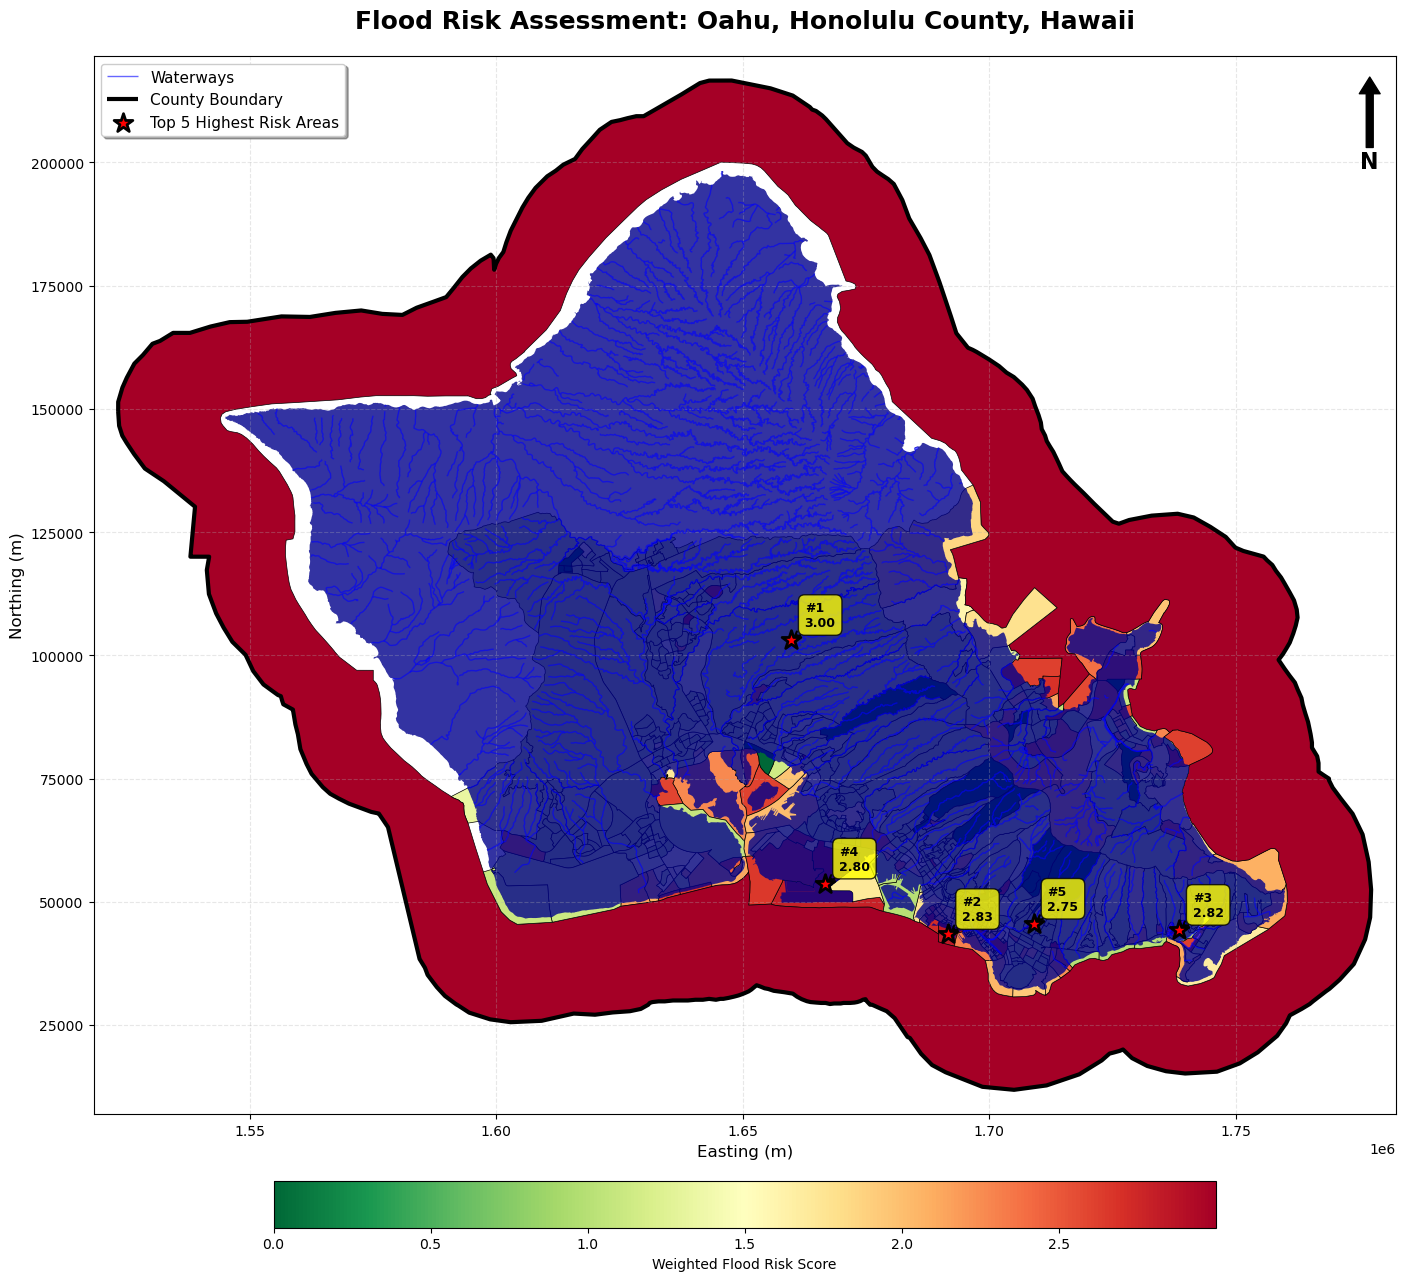

✓ Comprehensive static map saved (Oahu only)


In [89]:

# Filter census_bg to Oahu only (exclude NW Hawaiian Islands)
census_bg['centroid_x'] = census_bg.geometry.centroid.x
census_bg['centroid_y'] = census_bg.geometry.centroid.y

x_median = census_bg['centroid_x'].median()
x_std = census_bg['centroid_x'].std()
y_median = census_bg['centroid_y'].median()
y_std = census_bg['centroid_y'].std()

census_bg_oahu = census_bg[
    (census_bg['centroid_x'] > (x_median - 2*x_std)) &
    (census_bg['centroid_x'] < (x_median + 2*x_std)) &
    (census_bg['centroid_y'] > (y_median - 2*y_std)) &
    (census_bg['centroid_y'] < (y_median + 2*y_std))
].copy()

census_bg_oahu = census_bg_oahu.drop(columns=['centroid_x', 'centroid_y'])

# Get Oahu bounds for clipping other layers
oahu_bounds = census_bg_oahu.total_bounds  # [minx, miny, maxx, maxy]

print(f"✓ Filtered to Oahu: {len(census_bg_oahu)} block groups")


fig, ax = plt.subplots(1, 1, figsize=(16, 14))

# Plot risk classification - USE OAHU ONLY
census_bg_oahu.plot(
    column='weighted_risk_score',
    ax=ax,
    legend=True,
    cmap='RdYlGn_r',
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={
        'label': 'Weighted Flood Risk Score',
        'orientation': 'horizontal',
        'shrink': 0.6,
        'pad': 0.05
    }
)

# Overlay water features
waterways.plot(ax=ax, color='blue', linewidth=1, alpha=0.6, label='Waterways')
lines.plot(ax=ax, color='darkblue', linewidth=2, alpha=0.8, label='Coastline')

# Add county boundary
honolulu.boundary.plot(ax=ax, color='black', linewidth=3, label='County Boundary')

# Mark top 5 highest risk areas - USE OAHU ONLY
top_5 = census_bg_oahu.nlargest(5, 'weighted_risk_score')
top_5_centroids = top_5.geometry.centroid

ax.scatter(
    top_5_centroids.x, 
    top_5_centroids.y, 
    color='red', 
    s=200, 
    marker='*', 
    edgecolor='black', 
    linewidth=2,
    label='Top 5 Highest Risk Areas',
    zorder=5
)

# Add labels for top risk areas
for idx, (x, y, score) in enumerate(zip(top_5_centroids.x, top_5_centroids.y, top_5['weighted_risk_score'])):
    ax.annotate(
        f'#{idx+1}\n{score:.2f}',
        xy=(x, y),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1.5)
    )

# SET AXIS LIMITS TO OAHU BOUNDS (with small buffer)
buffer = 5000  # 5km buffer
ax.set_xlim(oahu_bounds[0] - buffer, oahu_bounds[2] + buffer)
ax.set_ylim(oahu_bounds[1] - buffer, oahu_bounds[3] + buffer)

# Add legend
ax.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True)

# Add title and labels
ax.set_title('Flood Risk Assessment: Oahu, Honolulu County, Hawaii', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)

# Add north arrow
x, y, arrow_length = 0.98, 0.98, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=16, fontweight='bold',
            xycoords=ax.transAxes)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('outputs/figures/10_comprehensive_risk_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive static map saved (Oahu only)")

In [90]:
# Fix truncated shapefile column names
census_bg = census_bg.rename(columns={
    'total_popu': 'total_population',
    'pixels_mod': 'pixels_moderate',
    'pixels_hig': 'pixels_high',
    'pixels_tot': 'pixels_total',
    'pct_modera': 'pct_moderate',
    'pop_low_ri': 'pop_low_risk',
    'pop_modera': 'pop_moderate_risk',
    'pop_high_r': 'pop_high_risk',
    'dominant_r': 'dominant_risk',
    'weighted_r': 'weighted_risk_score'
})
print("✓ Column names restored")

✓ Column names restored


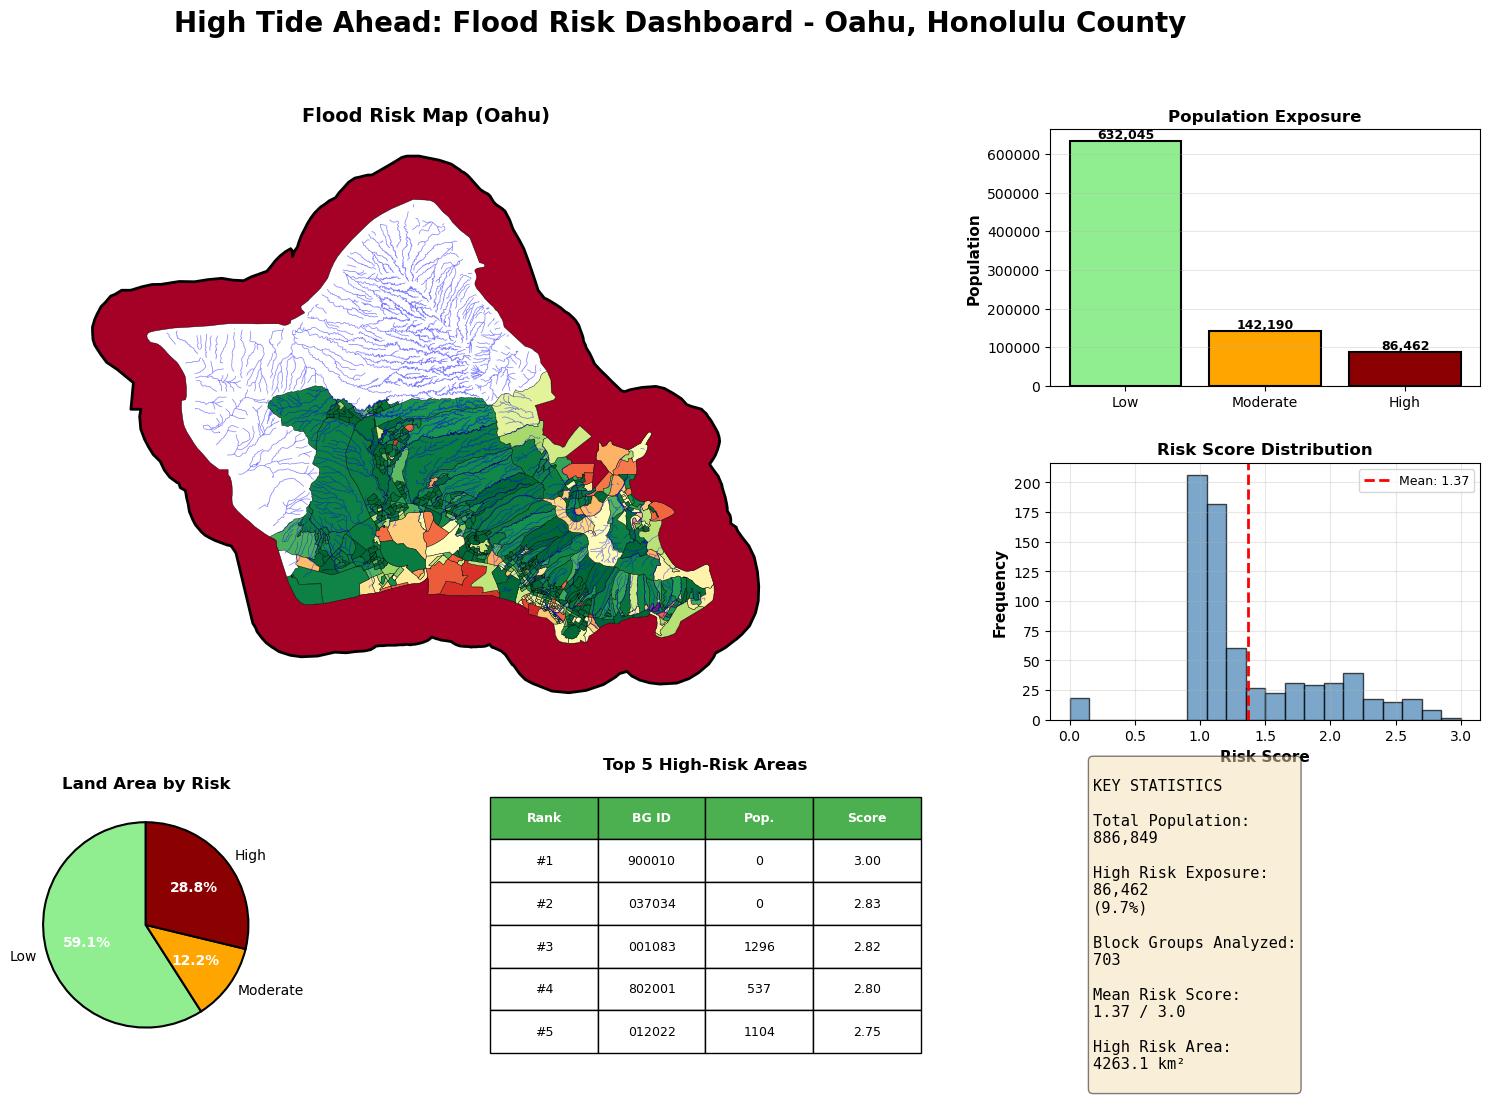

✓ Dashboard summary figure saved (Oahu only)


In [91]:
# Create Dashboard-Style Summary Figure - OAHU ONLY
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Filter to Oahu only first
census_bg['centroid_x'] = census_bg.geometry.centroid.x
census_bg['centroid_y'] = census_bg.geometry.centroid.y

x_median = census_bg['centroid_x'].median()
x_std = census_bg['centroid_x'].std()
y_median = census_bg['centroid_y'].median()
y_std = census_bg['centroid_y'].std()

census_bg_oahu = census_bg[
    (census_bg['centroid_x'] > (x_median - 2*x_std)) &
    (census_bg['centroid_x'] < (x_median + 2*x_std)) &
    (census_bg['centroid_y'] > (y_median - 2*y_std)) &
    (census_bg['centroid_y'] < (y_median + 2*y_std))
].copy()

census_bg_oahu = census_bg_oahu.drop(columns=['centroid_x', 'centroid_y'], errors='ignore')

# Get Oahu bounds for clipping
bounds = census_bg_oahu.total_bounds  # [minx, miny, maxx, maxy]
x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]

# Add buffer around Oahu
buffer_pct = 0.05
x_buffer = x_range * buffer_pct
y_buffer = y_range * buffer_pct

# Panel 1: Main risk map - OAHU ONLY
ax1 = fig.add_subplot(gs[0:2, 0:2])

census_bg_oahu.plot(
    column='weighted_risk_score',
    ax=ax1,
    cmap='RdYlGn_r',
    edgecolor='black',
    linewidth=0.3,
    legend=False,
    vmin=1,
    vmax=3
)
waterways.plot(ax=ax1, color='blue', linewidth=0.5, alpha=0.5)
honolulu.boundary.plot(ax=ax1, color='black', linewidth=2)

# Clip to Oahu only
ax1.set_xlim([bounds[0] - x_buffer, bounds[2] + x_buffer])
ax1.set_ylim([bounds[1] - y_buffer, bounds[3] + y_buffer])
ax1.set_facecolor('lightblue')  # Water background

ax1.set_title('Flood Risk Map (Oahu)', fontsize=14, fontweight='bold')
ax1.axis('off')

# Panel 2: Population exposure bar chart - UPDATED COLUMN NAMES
ax2 = fig.add_subplot(gs[0, 2])
risk_cats = ['Low', 'Moderate', 'High']
pop_exp = [
    census_bg_oahu['pop_low_risk'].sum(),
    census_bg_oahu['pop_moderate_risk'].sum(),
    census_bg_oahu['pop_high_risk'].sum()
]
colors_bar = ['lightgreen', 'orange', 'darkred']
bars = ax2.bar(risk_cats, pop_exp, color=colors_bar, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Population', fontsize=11, fontweight='bold')
ax2.set_title('Population Exposure', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, pop_exp):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Panel 3: Risk score distribution
ax3 = fig.add_subplot(gs[1, 2])
ax3.hist(census_bg_oahu['weighted_risk_score'], bins=20, color='steelblue', 
         edgecolor='black', alpha=0.7)
ax3.axvline(census_bg_oahu['weighted_risk_score'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f"Mean: {census_bg_oahu['weighted_risk_score'].mean():.2f}")
ax3.set_xlabel('Risk Score', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Risk Score Distribution', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# Panel 4: Area by risk category (pie chart)
ax4 = fig.add_subplot(gs[2, 0])

# Calculate areas
with rasterio.open(risk_raster_path) as src:
    risk_data = src.read(1)
    pixel_area_km2 = (src.res[0] ** 2) / 1e6

areas = []
for risk_val in [1, 2, 3]:
    pixels = np.sum(risk_data == risk_val)
    area_km2 = pixels * pixel_area_km2
    areas.append(area_km2)

wedges, texts, autotexts = ax4.pie(
    areas, 
    labels=risk_cats, 
    autopct='%1.1f%%',
    colors=colors_bar,
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title('Land Area by Risk', fontsize=12, fontweight='bold')

# Panel 5: Top 5 highest risk block groups
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')
top_5_bg = census_bg_oahu.nlargest(5, 'weighted_risk_score')
table_data = []
for i, (idx, row) in enumerate(top_5_bg.iterrows(), 1):
    table_data.append([
        f"#{i}",
        row['GEOID'][-6:],  # Last 6 digits
        f"{row['total_population']:.0f}",
        f"{row['weighted_risk_score']:.2f}"
    ])

table = ax5.table(
    cellText=table_data,
    colLabels=['Rank', 'BG ID', 'Pop.', 'Score'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax5.set_title('Top 5 High-Risk Areas', fontsize=12, fontweight='bold', pad=20)

# Panel 6: Key statistics - UPDATED COLUMN NAMES
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

total_pop = census_bg_oahu['total_population'].sum()
high_risk_pop = census_bg_oahu['pop_high_risk'].sum()
high_risk_pct = high_risk_pop / total_pop * 100 if total_pop > 0 else 0

stats_text = f"""
KEY STATISTICS

Total Population:
{total_pop:,.0f}

High Risk Exposure:
{high_risk_pop:,.0f}
({high_risk_pct:.1f}%)

Block Groups Analyzed:
{len(census_bg_oahu)}

Mean Risk Score:
{census_bg_oahu['weighted_risk_score'].mean():.2f} / 3.0

High Risk Area:
{areas[2]:.1f} km²
"""

ax6.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Overall title
fig.suptitle('High Tide Ahead: Flood Risk Dashboard - Oahu, Honolulu County', 
             fontsize=20, fontweight='bold', y=0.98)

plt.savefig('outputs/figures/11_dashboard_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dashboard summary figure saved (Oahu only)")

In [93]:
# Create simplified GeoJSON for web mapping (smaller file size)
census_simplified = census_bg_wgs84[[
    'GEOID', 'total_population', 'weighted_risk_score', 
    'dominant_risk', 'pct_high', 'pop_high_risk', 'geometry'
]].copy()

# Round coordinates to reduce file size
census_simplified['geometry'] = census_simplified['geometry'].simplify(0.0001)

# Save simplified version
census_simplified.to_file('outputs/maps/census_risk_simplified.geojson', driver='GeoJSON')
print("✓ Simplified GeoJSON exported for web use")

# Export summary statistics as JSON
summary_stats = {
    "total_population": int(census_bg['total_population'].sum()),
    "population_high_risk": int(census_bg['pop_high_risk'].sum()),
    "population_moderate_risk": int(census_bg['pop_moderate_risk'].sum()),
    "population_low_risk": int(census_bg['pop_low_risk'].sum()),
    "percent_high_risk": round((census_bg['pop_high_risk'].sum() / census_bg['total_population'].sum()) * 100, 2),
    "block_groups_total": len(census_bg),
    "mean_risk_score": round(census_bg['weighted_risk_score'].mean(), 2),
    "median_risk_score": round(census_bg['weighted_risk_score'].median(), 2),
    "area_high_risk_km2": round(areas[2], 2),
    "area_moderate_risk_km2": round(areas[1], 2),
    "area_low_risk_km2": round(areas[0], 2),
    "top_5_highest_risk": [
        {
            "geoid": row['GEOID'],
            "population": int(row['total_population']),
            "risk_score": round(row['weighted_risk_score'], 2),
            "percent_high_risk": round(row['pct_high'], 1)
        }
        for _, row in census_bg.nlargest(5, 'weighted_risk_score').iterrows()
    ]
}

with open('outputs/data/summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
    
print("✓ Summary statistics exported as JSON")

✓ Simplified GeoJSON exported for web use
✓ Summary statistics exported as JSON


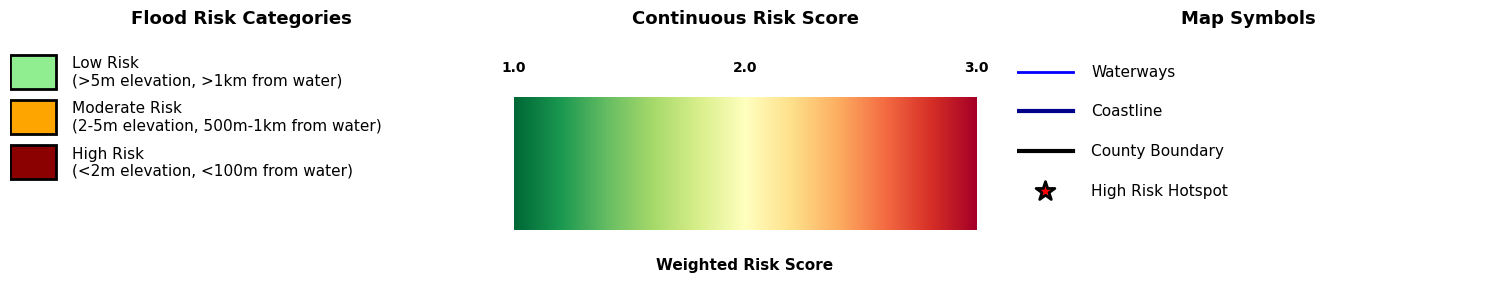

✓ Legend graphics saved


In [94]:
# Create standalone legend graphics
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Legend 1: Risk Categories
ax1 = axes[0]
ax1.axis('off')
colors_legend = ['lightgreen', 'orange', 'darkred']
labels_legend = ['Low Risk\n(>5m elevation, >1km from water)', 
                 'Moderate Risk\n(2-5m elevation, 500m-1km from water)', 
                 'High Risk\n(<2m elevation, <100m from water)']
for i, (color, label) in enumerate(zip(colors_legend, labels_legend)):
    ax1.add_patch(plt.Rectangle((0, 2-i*0.8), 0.3, 0.6, facecolor=color, edgecolor='black', linewidth=2))
    ax1.text(0.4, 2-i*0.8+0.3, label, fontsize=11, va='center')
ax1.set_xlim(0, 3)
ax1.set_ylim(-0.5, 3)
ax1.set_title('Flood Risk Categories', fontsize=13, fontweight='bold')

# Legend 2: Risk Score Scale
ax2 = axes[1]
ax2.axis('off')
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax2.imshow(gradient, aspect='auto', cmap='RdYlGn_r', extent=[1, 3, 0, 1])
ax2.set_xlim(1, 3)
ax2.set_ylim(0, 1.5)
ax2.text(1, 1.2, '1.0', fontsize=10, ha='center', fontweight='bold')
ax2.text(2, 1.2, '2.0', fontsize=10, ha='center', fontweight='bold')
ax2.text(3, 1.2, '3.0', fontsize=10, ha='center', fontweight='bold')
ax2.text(2, -0.3, 'Weighted Risk Score', fontsize=11, ha='center', fontweight='bold')
ax2.set_title('Continuous Risk Score', fontsize=13, fontweight='bold')

# Legend 3: Map Symbols
ax3 = axes[2]
ax3.axis('off')
ax3.plot([0, 0.3], [2.5, 2.5], 'b-', linewidth=2, label='Waterways')
ax3.plot([0, 0.3], [2, 2], color='darkblue', linewidth=3, label='Coastline')
ax3.plot([0, 0.3], [1.5, 1.5], 'k-', linewidth=3, label='County Boundary')
ax3.scatter([0.15], [1], color='red', s=200, marker='*', edgecolor='black', linewidth=2, label='High Risk Hotspot')
for i, (y, label) in enumerate([(2.5, 'Waterways'), (2, 'Coastline'), (1.5, 'County Boundary'), (1, 'High Risk Hotspot')]):
    ax3.text(0.4, y, label, fontsize=11, va='center')
ax3.set_xlim(0, 2.5)
ax3.set_ylim(0.5, 3)
ax3.set_title('Map Symbols', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/figures/12_legends.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Legend graphics saved")

In [96]:
# Print comprehensive file checklist
print("="*70)
print("VISUALIZATION COMPLETE - FILE CHECKLIST")
print("="*70)

print("\n📁 OUTPUT FILES CREATED:")

print("\n  Interactive Maps:")
print("    ✓ outputs/maps/flood_risk_interactive_map.html")
print("    ✓ outputs/maps/census_risk_simplified.geojson")

print("\n  Static Figures:")
print("    ✓ outputs/figures/01_study_area.png")
print("    ✓ outputs/figures/02_all_processed_data.png")
print("    ✓ outputs/figures/03_elevation_risk.png")
print("    ✓ outputs/figures/04_water_buffers.png")
print("    ✓ outputs/figures/05_proximity_risk.png")
print("    ✓ outputs/figures/06_composite_flood_risk.png")
print("    ✓ outputs/figures/07_population_exposure_maps.png")
print("    ✓ outputs/figures/08_dominant_risk_categories.png")
print("    ✓ outputs/figures/09_statistical_analysis.png")
print("    ✓ outputs/figures/10_comprehensive_risk_map.png")
print("    ✓ outputs/figures/11_dashboard_summary.png")
print("    ✓ outputs/figures/12_legends.png")

print("\n  Processed Data:")
print("    ✓ data/processed/honolulu_boundary.shp")
print("    ✓ data/processed/waterways_honolulu.shp")
print("    ✓ data/processed/lines_honolulu.shp")
print("    ✓ data/processed/census_bg_honolulu.shp")
print("    ✓ data/processed/dem_honolulu.tif")
print("    ✓ data/processed/elevation_risk.tif")
print("    ✓ data/processed/proximity_risk.tif")
print("    ✓ data/processed/composite_risk.tif")
print("    ✓ data/processed/final_flood_risk.tif")
print("    ✓ data/processed/census_bg_with_risk.shp")
print("    ✓ data/processed/census_bg_with_risk.geojson")

print("\n  Data Tables:")
print("    ✓ outputs/data/population_risk_profile.csv")
print("    ✓ outputs/data/exposure_summary.csv")
print("    ✓ outputs/data/summary_statistics.json")

print("\n" + "="*70)
print("✓ ALL VISUALIZATIONS COMPLETE!")
print("="*70)

VISUALIZATION COMPLETE - FILE CHECKLIST

📁 OUTPUT FILES CREATED:

  Interactive Maps:
    ✓ outputs/maps/flood_risk_interactive_map.html
    ✓ outputs/maps/census_risk_simplified.geojson

  Static Figures:
    ✓ outputs/figures/01_study_area.png
    ✓ outputs/figures/02_all_processed_data.png
    ✓ outputs/figures/03_elevation_risk.png
    ✓ outputs/figures/04_water_buffers.png
    ✓ outputs/figures/05_proximity_risk.png
    ✓ outputs/figures/06_composite_flood_risk.png
    ✓ outputs/figures/07_population_exposure_maps.png
    ✓ outputs/figures/08_dominant_risk_categories.png
    ✓ outputs/figures/09_statistical_analysis.png
    ✓ outputs/figures/10_comprehensive_risk_map.png
    ✓ outputs/figures/11_dashboard_summary.png
    ✓ outputs/figures/12_legends.png

  Processed Data:
    ✓ data/processed/honolulu_boundary.shp
    ✓ data/processed/waterways_honolulu.shp
    ✓ data/processed/lines_honolulu.shp
    ✓ data/processed/census_bg_honolulu.shp
    ✓ data/processed/dem_honolulu.tif
   